In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd 
import seaborn as sns 
from datetime import date
import time 

C:\Users\angel\AppData\Local\Temp\ipykernel_22836\3043399714.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Toy dataset

In [3]:
# covariance matrice 
def ind(i,j,k):
    # separates &,n into k blocks
    return int(i//k==j//k)


# Rank k-blocks covariance matrix : 
U=np.array([[ind(i,j,2) for j in range(10)] for i in range(10)])


# One Toeplitz matrix  
def toep (d):
  return np.array([[ (0.6)**abs(i-j) for i in range(d)]for j in range(d)])
print('U=')
print(U)
print('T=')
print(toep(6))

U=
[[1 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1]]
T=
[[1.      0.6     0.36    0.216   0.1296  0.07776]
 [0.6     1.      0.6     0.36    0.216   0.1296 ]
 [0.36    0.6     1.      0.6     0.36    0.216  ]
 [0.216   0.36    0.6     1.      0.6     0.36   ]
 [0.1296  0.216   0.36    0.6     1.      0.6    ]
 [0.07776 0.1296  0.216   0.36    0.6     1.     ]]


In [4]:
class ToysMissingDataset ():
    def __init__(self, n=1000,d=10, method='MCAR_cor2',eta=0.3,k=2, mu_0= None, mu_1=None):
        self.n= n
        self.d=d
        self.method = method # method used to build dataset 
        self.X = np.zeros((n,d))
        self.M= np.zeros((n,d)) # na occurences 
        self.y = np.zeros(n)
        self.eta=eta
        self.k=k # number of blocks in covariance matrix
        if mu_0 is None:
            self.mu_0=np.ones(d)
        else:
            self.mu_0=mu_0
        if mu_1 is None:
            self.mu_1=-np.ones(d)
        else:
            self.mu_1=mu_1
        self.build(self.n)


    def build(self,n): 
      # build n observations according to a method 
        self.y=np.random.binomial(n=1, p=0.5, size=self.n)
        self.n=n
        self.X = np.zeros((n,self.d))
        self.M= np.zeros((n,self.d))
        if self.method =='MCAR_iso': 
            # Generate a simple MCAR distribution, with isotrope observation 
            self.X= np.random.normal(size=(self.n,self.d))


        elif self.method =='MCAR_cor': 
            # Generate a simple MCAR distribution, with anisotropic observations and Sigma=U
            U= np.array([[ind(i,j,self.k) for j in range(self.d)] for i in range(self.d)])/np.sqrt(self.k)
            self.X= np.random.normal(size=(self.n,self.d))@U+np.ones(self.d)

        elif self.method =='MCAR_cor2': 
            # Generate un simpler MCAR distribution, with anisotropic observations and Sigma=Toepliz
            self.X= np.random.multivariate_normal(np.zeros(self.d),toep(self.d),size=self.n)
            

        else :
          print("WARNING: key word")
        for i in range(n):
            if self.y[i]==0:
                self.X[i]+=self.mu_0
            else:
                self.X[i]+=self.mu_1
        self.M= np.random.binomial(n=1,p=self.eta, size=(self.n,self.d))
        self.X[self.M==1]=np.nan # missing data masked 

  
    def data(self):
        return self.X,self.M,self.y

In [5]:
data=ToysMissingDataset(n=1000, d=2, eta=0)


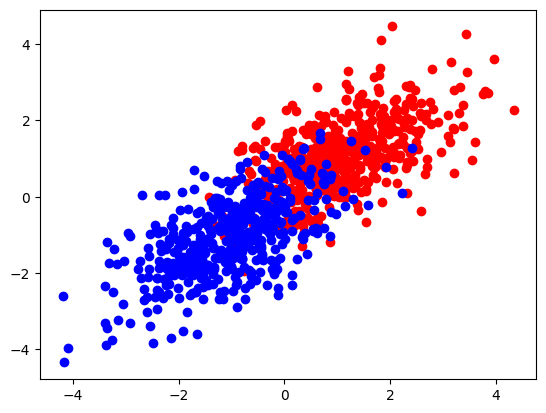

In [6]:
X, M, y=data.data()
plt.scatter(X[y==0, 0], X[y==0,1], color="red", label="Class 0")
plt.scatter(X[y==1,0], X[y==1,1], color="blue", label="Class 1")

## Methods

General class

In [7]:
class Classification ():
  def __init__(self,name=''):
    self.name=name # Name will use for plot

  def test_error(self,X,M,y):
    return np.mean(np.abs(self.predict(X,M)-y))# Classes are either 0 or 1

### Logistic Regression

Imputed by 0

In [8]:
class RegLog0imputation (Classification):
  def fit(self,X,M,y):
    Xp=X.copy()
    Xp[M==1]=0 
    self.reg = LogisticRegression(penalty=None).fit(np.hstack((Xp,M)), y)# we had M to covariate

  def predict(self,X,M):
    Xp=X.copy()
    Xp[M==1]=0 
    return self.reg.predict(np.hstack((Xp,M)))


In [9]:
toys = ToysMissingDataset(n=1000, d=2)
X_train,M_train,y_train= toys.X[:100],toys.M[:100],toys.y[:100]
X_test,M_test,y_test= toys.X[100:],toys.M[100:],toys.y[100:]

reg =RegLog0imputation(name='RL-OImput')
reg.fit(X_train,M_train,y_train)
reg.test_error(X_test,M_test,y_test)

0.21222222222222223

Pattern-by-pattern

In [10]:
class RegLogPatByPat (Classification):

    def fit(self,X,M,y):
        self.X=X.copy()
        self.M=M
        self.y=y
        self.dic={}
        self.m=np.argmax(y)
        for i in range (len(M)):
                if not(str(M[i]) in self.dic) and np.product(M[i])==0:
                    n =len(self.X)
                    S=np.asarray([np.product(M[j]==M[i]) for j in range(n) ]) # sample with less na than M[i]
                    Xp=self.X[S==1][:,M[i]==0]
                    yp= self.y[S==1]
                    reg = LogisticRegression(n_jobs=-1, penalty=None).fit(np.array(Xp,ndmin=2), yp)
                    self.dic[str(self.M[i])]=reg

        
    def pred(self,X,m):
        m=np.asarray(m)
        if not(str(m) in self.dic) or np.product(m)==1 :
            return self.m
        else: 
            reg = self.dic[str(m)]
            return reg.predict(np.array(X[m==0], ndmin=2))[0]

    def predict(self,X,M):
        n= len(X)
        prediction=np.array([ self.pred(X[i],M[i]) for i in range(n)], ndmin=2)
        return prediction

In [11]:
toys = ToysMissingDataset(n=1000, d=2)
X_train,M_train,y_train= toys.X[:100],toys.M[:100],toys.y[:100]
X_test,M_test,y_test= toys.X[100:],toys.M[100:],toys.y[100:]

reg =RegLogPatByPat(name='RL-p-b-p')
reg.fit(X_train,M_train,y_train)
reg.test_error(X_test,M_test,y_test)

### Iterative imputer

In [ ]:
class RegLogICEimputation (Classification):
  def fit(self,X,M,y):
    Xp=X.copy()
    self.imp_mean = IterativeImputer(random_state=0)
    self.imp_mean.fit(Xp)
    Xp=self.imp_mean.transform(Xp)
    self.reg = LogisticRegression(penalty=None).fit(np.hstack((Xp,M)), y)# we had M to covariate

  def predict(self,X,M):
    Xp=X.copy()
    Xp=self.imp_mean.transform(Xp) 
    return self.reg.predict(np.hstack((Xp,M)))

In [ ]:
toys = ToysMissingDataset(n=1000, d=2)
X_train,M_train,y_train= toys.X[:100],toys.M[:100],toys.y[:100]
X_test,M_test,y_test= toys.X[100:],toys.M[100:],toys.y[100:]

reg =RegLogICEimputation(name='RL-ICE')
reg.fit(X_train,M_train,y_train)
reg.test_error(X_test,M_test,y_test)

0.1688888888888889

## Perceptron

Imputed by 0

In [ ]:
class Percep0imputation (Classification):
  def fit(self,X,M,y):
    Xp=X.copy()
    Xp[M==1]=0 
    self.reg = Perceptron().fit(np.hstack((Xp,M)), y)# we had M to covariate

  def predict(self,X,M):
    Xp=X.copy()
    Xp[M==1]=0 
    return self.reg.predict(np.hstack((Xp,M)))

In [ ]:
toys = ToysMissingDataset(n=1000, d=2)
X_train,M_train,y_train= toys.X[:100],toys.M[:100],toys.y[:100]
X_test,M_test,y_test= toys.X[100:],toys.M[100:],toys.y[100:]

reg =Percep0imputation(name='Percep-OImput')
reg.fit(X_train,M_train,y_train)
reg.test_error(X_test,M_test,y_test)

0.18555555555555556

Pattern-by-pattern

In [ ]:
class PercepPatByPat (Classification):

    def fit(self,X,M,y):
        self.X=X.copy()
        self.M=M
        self.y=y
        self.dic={}
        self.m=np.argmax(y)
        for i in range (len(M)):
                if not(str(M[i]) in self.dic) and np.product(M[i])==0:
                    n =len(self.X)
                    S=np.asarray([np.product(M[j]==M[i]) for j in range(n) ]) # sample with less na than M[i]
                    Xp=self.X[S==1][:,M[i]==0]
                    yp= self.y[S==1]
                    reg = Perceptron(n_jobs=-1).fit(np.array(Xp,ndmin=2), yp)
                    self.dic[str(self.M[i])]=reg

        
    def pred(self,X,m):
        m=np.asarray(m)
        if not(str(m) in self.dic) or np.product(m)==1 :
            return self.m
        else: 
            reg = self.dic[str(m)]
            return reg.predict(np.array(X[m==0], ndmin=2))[0]

    def predict(self,X,M):
        n= len(X)
        prediction=np.array([ self.pred(X[i],M[i]) for i in range(n)], ndmin=2)
        return prediction

In [ ]:
toys = ToysMissingDataset(n=1000, d=2)
X_train,M_train,y_train= toys.X[:100],toys.M[:100],toys.y[:100]
X_test,M_test,y_test= toys.X[100:],toys.M[100:],toys.y[100:]

reg =PercepPatByPat(name='Percep-p-b-p')
reg.fit(X_train,M_train,y_train)
reg.test_error(X_test,M_test,y_test)

0.21

Iterative Imputer

In [ ]:
class PercepICEimputation (Classification):
  def fit(self,X,M,y):
    Xp=X.copy()
    self.imp_mean = IterativeImputer(random_state=0)
    self.imp_mean.fit(Xp)
    Xp=self.imp_mean.transform(Xp)
    self.reg = Perceptron().fit(np.hstack((Xp,M)), y)# we had M to covariate

  def predict(self,X,M):
    Xp=X.copy()
    Xp=self.imp_mean.transform(Xp) 
    return self.reg.predict(np.hstack((Xp,M)))

In [ ]:
toys = ToysMissingDataset(n=1000, d=2)
X_train,M_train,y_train= toys.X[:100],toys.M[:100],toys.y[:100]
X_test,M_test,y_test= toys.X[100:],toys.M[100:],toys.y[100:]

reg =PercepICEimputation(name='Percep-ICE')
reg.fit(X_train,M_train,y_train)
reg.test_error(X_test,M_test,y_test)

0.17666666666666667

### LDA

Imputed by 0

In [ ]:
class LDA0imputation (Classification):
  def fit(self,X,M,y, sigma):
    Xp=X.copy()
    Xp[M==1]=0 
    self.mu_0=np.mean(Xp[y==0], axis=0)
    self.mu_1=np.mean(Xp[y==1], axis=0)
    self.sigma=sigma

  def predict(self,X,M):
    Xp=X.copy()
    Xp[M==1]=0 
    return (np.dot( Xp-(self.mu_1+self.mu_0)/2, np.dot((self.mu_1-self.mu_0), np.linalg.inv(self.sigma)))>=0)

In [ ]:
d=2

toys = ToysMissingDataset(n=1000, d=d)
X_train,M_train,y_train= toys.X[:100],toys.M[:100],toys.y[:100]
X_test,M_test,y_test= toys.X[100:],toys.M[100:],toys.y[100:]

reg =LDA0imputation(name='LDA-OImput')
reg.fit(X_train,M_train,y_train, sigma= toep(d))
reg.test_error(X_test,M_test,y_test)

0.15444444444444444

Iterative imputer

In [ ]:
class LDAICEimputation (Classification):
  def fit(self,X,M,y, sigma):
    Xp=X.copy()
    self.imp_mean = IterativeImputer(random_state=0)
    self.imp_mean.fit(Xp)
    Xp=self.imp_mean.transform(Xp)
    self.mu_0=np.mean(Xp[y==0], axis=0)
    self.mu_1=np.mean(Xp[y==1], axis=0)
    self.sigma=sigma

  def predict(self,X,M):
    Xp=X.copy()
    Xp=self.imp_mean.transform(Xp) 
    return (np.dot( Xp-(self.mu_1+self.mu_0)/2, np.dot((self.mu_1-self.mu_0), np.linalg.inv(self.sigma)))>=0)

In [ ]:
d=2
toys = ToysMissingDataset(n=1000, d=d)
X_train,M_train,y_train= toys.X[:100],toys.M[:100],toys.y[:100]
X_test,M_test,y_test= toys.X[100:],toys.M[100:],toys.y[100:]

reg =LDAICEimputation(name='LDA-ICEImput')
reg.fit(X_train,M_train,y_train, sigma= toep(d))
reg.test_error(X_test,M_test,y_test)

0.14444444444444443

LDA with MCAR data

In [ ]:
class LDA_MCAR (Classification):
  def fit(self,X,M,y, sigma):
    Xp=X.copy()
    self.sigma=sigma
    self.mu_0=np.nanmean(Xp[y==0], axis=0)
    self.mu_1=np.nanmean(Xp[y==1], axis=0)
    self.dic_cov={}# To avoid recomputing the inverse of the covariance
    for i in range (len(M)):
            if not(str(M[i]) in self.dic_cov) and (sum(M[i]==0)>1):
                self.dic_cov[str(M[i])]=np.linalg.inv(self.sigma[np.ix_(M[i]==0, M[i]==0)])


  def pred(self,X,m):
        m=np.asarray(m)
        if  np.product(m)==1 :
            return np.random.binomial(n=1, p=0.5)
        if not(str(m) in self.dic_cov) :
            if np.sum(m==0)==1:#Only one observed
                return int((self.mu_1[m==0]-self.mu_0[m==0])* 1/self.sigma[m==0, m==0]*(X[m==0]-(self.mu_1[m==0]+self.mu_0[m==0])/2)>=0)
            else:
                self.dic_cov[str(m)]=np.linalg.inv(self.sigma[np.ix_(m==0, m==0)])
        return int(np.dot(np.dot((self.mu_1[m==0]-self.mu_0[m==0]), self.dic_cov[str(m)]), X[m==0]-(self.mu_1[m==0]+self.mu_0[m==0])/2)>=0)
    
            
  def predict(self,X,M):
      n= len(X)
      prediction=np.array([ self.pred(X[i],M[i]) for i in range(n)], ndmin=2)
      return prediction

In [ ]:
d=2
toys = ToysMissingDataset(n=1000, d=d)
X_train,M_train,y_train= toys.X[:100],toys.M[:100],toys.y[:100]
X_test,M_test,y_test= toys.X[100:],toys.M[100:],toys.y[100:]

reg =LDA_MCAR(name='LDA-MCAR')
reg.fit(X_train,M_train,y_train, sigma= toep(d))
reg.test_error(X_test,M_test,y_test)

0.1711111111111111

LDA P-b-P

In [ ]:
class LDA_pbp (Classification):
  def fit(self,X,M,y, sigma):
    Xp=X.copy()
    self.sigma=sigma
    self.dic_cov={}# To avoid recomputing the inverse of the covariance
    self.dic_mu_0={}
    self.dic_mu_1={}
    for i in range (len(M)):
            if not(str(M[i]) in self.dic_cov) and (sum(M[i]==0)>1):
                self.dic_cov[str(M[i])]=np.linalg.inv(self.sigma[np.ix_(M[i]==0, M[i]==0)])
            elif not(str(M[i]) in self.dic_mu_0) and np.product(M[i])==0:
                indices_0=(np.array(y==0) & np.all(M==M[i], axis=1))
                indices_1=(np.array(y==1) & np.all(M==M[i], axis=1))
                Xp2=Xp[:,M[i]==0]
                self.dic_mu_0[str(M[i])]=np.mean(Xp2[indices_0], axis=0)
                self.dic_mu_1[str(M[i])]=np.mean(Xp2[indices_1], axis=0)

  def pred(self,X,m):
        m=np.asarray(m)
        if  np.product(m)==1 or not(str(m) in self.dic_mu_0):
            return np.random.binomial(n=1, p=0.5)
        if not(str(m) in self.dic_cov) :
            if np.sum(m==0)==1:#Only one observed
                return int((self.dic_mu_1[str(m)]-self.dic_mu_0[str(m)])* 1/self.sigma[m==0, m==0]*(X[m==0]-(self.dic_mu_1[str(m)]+self.dic_mu_0[str(m)])/2)>=0)
            else:
                self.dic_cov[str(m)]=np.linalg.inv(self.sigma[np.ix_(m==0, m==0)])
        return int(np.dot(np.dot((self.dic_mu_1[str(m)]-self.dic_mu_0[str(m)]), self.dic_cov[str(m)]), X[m==0]-(self.dic_mu_1[str(m)]+self.dic_mu_0[str(m)])/2)>=0)
    
            
  def predict(self,X,M):
      n= len(X)
      prediction=np.array([ self.pred(X[i],M[i]) for i in range(n)], ndmin=2)
      return prediction

In [ ]:
d=2
toys = ToysMissingDataset(n=1000, d=d)
X_train,M_train,y_train= toys.X[:100],toys.M[:100],toys.y[:100]
X_test,M_test,y_test= toys.X[100:],toys.M[100:],toys.y[100:]

reg =LDA_pbp(name='LDA-pbp')
reg.fit(X_train,M_train,y_train, sigma= toep(d))
reg.test_error(X_test,M_test,y_test)

0.18444444444444444

# Simulations

## Different samples

In [ ]:
def df_test (regresseur,gen,lst_n=[], n_test=1000,repeat=3,title="",seed=0,b_risk=0, sigma=None): 
    # test regressor in regresseur brtween n_min and n_max
    
    np.random.seed(seed)
    title= gen(3).method
    n_max=lst_n[-1]
    
    lst_toys = [gen(n_max+n_test) for j in range(repeat)]
    df_res= pd.DataFrame({'n':[],'err':[],'Regressor':[], "Time":[]})
    for k in range(len(regresseur)):
      reg= regresseur[k]
      for n in lst_n:
        for toys in lst_toys:
            # data generation, data split
            X_train,M_train,y_train= toys.X[:n],toys.M[:n],toys.y[:n]
            X_test,M_test,y_test= toys.X[n_max:],toys.M[n_max:],toys.y[n_max:]
            d=X_train.shape[1]
            if isinstance(reg, (LDA0imputation, LDA_MCAR, LDA_pbp, LDAICEimputation) ):
              tic = time.perf_counter()
              reg.fit(X_train,M_train,y_train, sigma[0:d, 0:d])
              toc = time.perf_counter()
            else:
              tic = time.perf_counter()
              reg.fit(X_train,M_train,y_train)
              toc = time.perf_counter()
            new_row = pd.DataFrame([{'n': n, 'err': np.abs(reg.test_error(X_test, M_test, y_test) - b_risk), 'Regressor': reg.name, 'Time': toc - tic}])
            df_res = pd.concat([df_res, new_row], ignore_index=True)
    df_res.to_csv(title+str(repeat)+'.csv')
    return df_res

In [ ]:
# Simulated dataset 

d=5
k=2 #number of covariate by block 
eta=0.5
mu_0=-np.ones(d)
mu_1=np.ones(d)
def gen(n):
    return ToysMissingDataset(n=n,d=d,eta=eta,method='MCAR_cor2',k=k, mu_0=mu_0, mu_1=mu_1)



In [ ]:
lst_reg= [LDA_MCAR(name="LDA-MCAR"),
          LDA0imputation(name="0-imp+LDA"),
          LDAICEimputation(name= "ICE-imp+LDA"),
          LDA_pbp(name="pbp LDA"),
          RegLog0imputation(name='0-imp+LogReg'),
          RegLogICEimputation(name="ICE-imp+LogReg"),
          RegLogPatByPat( name="pbp LogReg"),
          Percep0imputation(name="0-imp+Perceptron"),
          PercepICEimputation(name="ICE-imp+Perceptron"),
          PercepPatByPat(name="pbp Perceptron")
          ]
df=df_test (lst_reg,gen,lst_n=[500, 1000, 2500, 5000, 10000], n_test=1000,repeat=10,title="Toeplitz",seed=0,b_risk=0, sigma=toep(d=d))


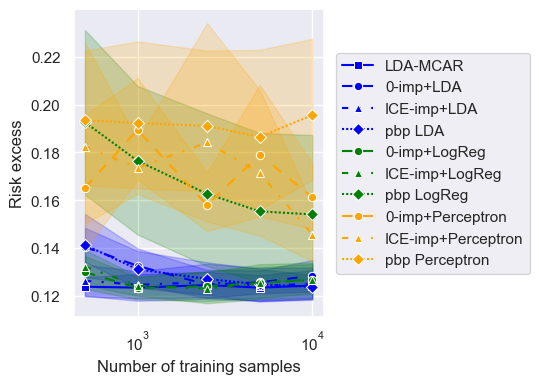

In [ ]:
# Learning curves : excess risk  
palette = {'LDA-MCAR': 'blue', '0-imp+LDA': 'blue', 'ICE-imp+LDA':'blue', 'pbp LDA':'blue', '0-imp+Perceptron':'orange', 'ICE-imp+Perceptron':'orange', 'pbp Perceptron': 'orange', '0-imp+LogReg': 'green', 'ICE-imp+LogReg':'green', 'pbp LogReg': 'green'}
markers = {'LDA-MCAR': 's', '0-imp+LDA': 'o', 'ICE-imp+LDA':'^', 'pbp LDA':'D', '0-imp+Perceptron':'o', 'ICE-imp+Perceptron':'^', 'pbp Perceptron': 'D', '0-imp+LogReg': 'o', 'ICE-imp+LogReg':'^', 'pbp LogReg': 'D'}
dashes = {'LDA-MCAR': (), '0-imp+LDA':(5, 5) , 'ICE-imp+LDA':(3, 5, 1, 5), 'pbp LDA':(1, 1), '0-imp+Perceptron':(5, 5), 'ICE-imp+Perceptron':(3, 5, 1, 5), 'pbp Perceptron': (1, 1), '0-imp+LogReg': (5, 5), 'ICE-imp+LogReg':(3, 5, 1, 5), 'pbp LogReg':(1, 1) }# (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={'figure.figsize':(4,4)})
sns.lineplot(data=df,x='n',y='err',hue='Regressor',palette=palette,style='Regressor',markers=markers, dashes=dashes)

#plt.ylim((1e-2,1e3))
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

plt.subplots_adjust(right=0.75)

plt.xscale('log')
#plt.yscale('log')


plt.ylabel('Risk excess')
plt.xlabel(r'Number of training samples')
plt.savefig('n-MCAR-cor2.pdf',bbox_inches = 'tight')
plt.show()

In [ ]:
lst_reg= [LDA_MCAR(name="LDA-MCAR"),
          LDA0imputation(name="0-imp+LDA"),
          LDAICEimputation(name= "ICE-imp+LDA"),
          LDA_pbp(name="pbp LDA"),
          RegLog0imputation(name='0-imp+LogReg'),
          RegLogICEimputation(name="ICE-imp+LogReg"),
          #RegLogPatByPat( name="pbp LogReg"),
          Percep0imputation(name="0-imp+Perceptron"),
          PercepICEimputation(name="ICE-imp+Perceptron"),
          #PercepPatByPat(name="pbp Perceptron")
          ]
df2=df_test (lst_reg,gen,lst_n=[30,40, 50,60, 75, 90], n_test=1000,repeat=10,title="Toeplitz",seed=0,b_risk=0, sigma=toep(d=d))


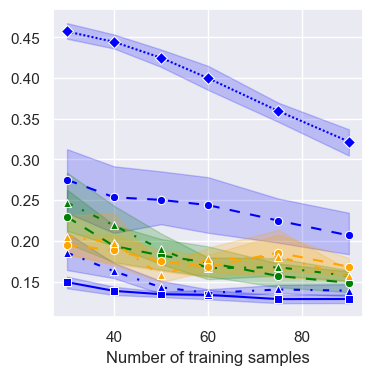

In [ ]:
# Learning curves : excess risk  
palette = {'LDA-MCAR': 'blue', '0-imp+LDA': 'blue', 'ICE-imp+LDA':'blue', 'pbp LDA':'blue', '0-imp+Perceptron':'orange', 'ICE-imp+Perceptron':'orange', 'pbp Perceptron': 'orange', '0-imp+LogReg': 'green', 'ICE-imp+LogReg':'green', 'pbp LogReg': 'green'}
markers = {'LDA-MCAR': 's', '0-imp+LDA': 'o', 'ICE-imp+LDA':'^', 'pbp LDA':'D', '0-imp+Perceptron':'o', 'ICE-imp+Perceptron':'^', 'pbp Perceptron': 'D', '0-imp+LogReg': 'o', 'ICE-imp+LogReg':'^', 'pbp LogReg': 'D'}
dashes = {'LDA-MCAR': (), '0-imp+LDA':(5, 5) , 'ICE-imp+LDA':(3, 5, 1, 5), 'pbp LDA':(1, 1), '0-imp+Perceptron':(5, 5), 'ICE-imp+Perceptron':(3, 5, 1, 5), 'pbp Perceptron': (1, 1), '0-imp+LogReg': (5, 5), 'ICE-imp+LogReg':(3, 5, 1, 5), 'pbp LogReg':(1, 1) }# (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={'figure.figsize':(4,4)})
sns.lineplot(data=df2,x='n',y='err',hue='Regressor',palette=palette,style='Regressor',markers=markers, dashes=dashes).get_legend().remove()

#plt.ylim((1e-2,1e3))
#plt.legend(loc=None)
#plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

#plt.subplots_adjust(right=0.75)

#plt.xscale('log')
#plt.yscale('log')


plt.ylabel('')
plt.xlabel(r'Number of training samples')
plt.savefig('n-MCAR-LDA-cor2.pdf',bbox_inches = 'tight')
plt.show()

### With MCAR-cor

In [ ]:
# Simulated dataset 

d=5
k=2 #number of covariate by block 
eta=0.5
mu_0=0.5*np.ones(d)
mu_1=2*np.ones(d)
def gen(n):
    return ToysMissingDataset(n=n,d=d,eta=eta,method='MCAR_iso',k=k, mu_0=mu_0, mu_1=mu_1)


In [ ]:
lst_reg= [LDA_MCAR(name="LDA-MCAR"),
          LDA0imputation(name="0-imp+LDA"),
          LDAICEimputation(name= "ICE-imp+LDA"),
          LDA_pbp(name="pbp LDA"),
          RegLog0imputation(name='0-imp+LogReg'),
          RegLogICEimputation(name="ICE-imp+LogReg"),
          RegLogPatByPat( name="pbp LogReg"),
          Percep0imputation(name="0-imp+Perceptron"),
          PercepICEimputation(name="ICE-imp+Perceptron"),
          PercepPatByPat(name="pbp Perceptron")
          ]
df=df_test (lst_reg,gen,lst_n=[500, 1000, 2500, 5000, 10000], n_test=1000,repeat=10,title="Isotropic",seed=0,b_risk=0, sigma=np.eye(d))

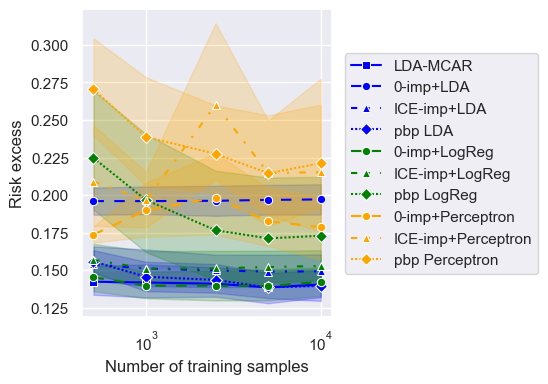

In [ ]:
# Learning curves : excess risk  
palette = {'LDA-MCAR': 'blue', '0-imp+LDA': 'blue', 'ICE-imp+LDA':'blue', 'pbp LDA':'blue', '0-imp+Perceptron':'orange', 'ICE-imp+Perceptron':'orange', 'pbp Perceptron': 'orange', '0-imp+LogReg': 'green', 'ICE-imp+LogReg':'green', 'pbp LogReg': 'green'}
markers = {'LDA-MCAR': 's', '0-imp+LDA': 'o', 'ICE-imp+LDA':'^', 'pbp LDA':'D', '0-imp+Perceptron':'o', 'ICE-imp+Perceptron':'^', 'pbp Perceptron': 'D', '0-imp+LogReg': 'o', 'ICE-imp+LogReg':'^', 'pbp LogReg': 'D'}
dashes = {'LDA-MCAR': (), '0-imp+LDA':(5, 5) , 'ICE-imp+LDA':(3, 5, 1, 5), 'pbp LDA':(1, 1), '0-imp+Perceptron':(5, 5), 'ICE-imp+Perceptron':(3, 5, 1, 5), 'pbp Perceptron': (1, 1), '0-imp+LogReg': (5, 5), 'ICE-imp+LogReg':(3, 5, 1, 5), 'pbp LogReg':(1, 1) }# (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={'figure.figsize':(4,4)})
sns.lineplot(data=df,x='n',y='err',hue='Regressor',palette=palette,style='Regressor',markers=markers, dashes=dashes)

#plt.ylim((1e-2,1e3))
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

plt.subplots_adjust(right=0.75)

plt.xscale('log')
#plt.yscale('log')


plt.ylabel('Risk excess')
plt.xlabel(r'Number of training samples')
plt.savefig('n-MCAR-iso.pdf',bbox_inches = 'tight')
plt.show()

In [ ]:
lst_reg= [LDA_MCAR(name="LDA-MCAR"),
          LDA0imputation(name="0-imp+LDA"),
          LDAICEimputation(name= "ICE-imp+LDA"),
          LDA_pbp(name="pbp LDA"),
          RegLog0imputation(name='0-imp+LogReg'),
          RegLogICEimputation(name="ICE-imp+LogReg"),
          #RegLogPatByPat( name="pbp LogReg"),
          Percep0imputation(name="0-imp+Perceptron"),
          PercepICEimputation(name="ICE-imp+Perceptron"),
          #PercepPatByPat(name="pbp Perceptron")
          ]

df2=df_test (lst_reg,gen,lst_n=[30,40, 50,60, 75, 90], n_test=1000,repeat=10,title="Isotropic",seed=0,b_risk=0, sigma=np.eye(d))


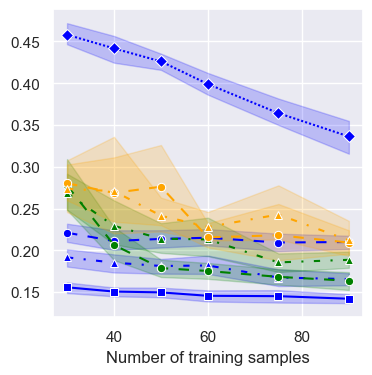

In [ ]:
# Learning curves : excess risk  
palette = {'LDA-MCAR': 'blue', '0-imp+LDA': 'blue', 'ICE-imp+LDA':'blue', 'pbp LDA':'blue', '0-imp+Perceptron':'orange', 'ICE-imp+Perceptron':'orange', 'pbp Perceptron': 'orange', '0-imp+LogReg': 'green', 'ICE-imp+LogReg':'green', 'pbp LogReg': 'green'}
markers = {'LDA-MCAR': 's', '0-imp+LDA': 'o', 'ICE-imp+LDA':'^', 'pbp LDA':'D', '0-imp+Perceptron':'o', 'ICE-imp+Perceptron':'^', 'pbp Perceptron': 'D', '0-imp+LogReg': 'o', 'ICE-imp+LogReg':'^', 'pbp LogReg': 'D'}
dashes = {'LDA-MCAR': (), '0-imp+LDA':(5, 5) , 'ICE-imp+LDA':(3, 5, 1, 5), 'pbp LDA':(1, 1), '0-imp+Perceptron':(5, 5), 'ICE-imp+Perceptron':(3, 5, 1, 5), 'pbp Perceptron': (1, 1), '0-imp+LogReg': (5, 5), 'ICE-imp+LogReg':(3, 5, 1, 5), 'pbp LogReg':(1, 1) }# (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={'figure.figsize':(4,4)})
sns.lineplot(data=df2,x='n',y='err',hue='Regressor',palette=palette,style='Regressor',markers=markers, dashes=dashes).get_legend().remove()

#plt.ylim((1e-2,1e3))
#plt.legend(loc=None)
#plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

#plt.subplots_adjust(right=0.75)

#plt.xscale('log')
#plt.yscale('log')

plt.ylabel('')
plt.xlabel(r'Number of training samples')
plt.savefig('n-MCAR2-LDA-iso.pdf',bbox_inches = 'tight')
plt.show()

## Different distances

In [ ]:
def df_test_dist (regresseur,gen_d,lst_dist=[],n_train=50, repeat=3,title="",seed=0,b_risk=0, sigma=None): 
    # test regressor in regresseur brtween n_min and n_max
    
    np.random.seed(seed)
    #title= gen_d(3).method
   
    
    lst_toys = [[gen_d(dist) for dist in lst_dist] for j in range(repeat)]
    df_res= pd.DataFrame({'dist':[],'err':[],'Regressor':[], "Time":[]})
    for k in range(len(regresseur)):
      reg= regresseur[k]
      for i in range(len(lst_dist)):
        for toys in lst_toys:
            # data generation, data split
            X_train,M_train,y_train= toys[i].X[:n_train],toys[i].M[:n_train],toys[i].y[:n_train]
            X_test,M_test,y_test= toys[i].X[n_train:],toys[i].M[n_train:],toys[i].y[n_train:]
            d=X_train.shape[1]
            if isinstance(reg, (LDA0imputation, LDA_MCAR, LDA_pbp, LDAICEimputation) ):
              tic = time.perf_counter()
              reg.fit(X_train,M_train,y_train, sigma[0:d, 0:d])
              toc = time.perf_counter()
            else:
              tic = time.perf_counter()
              reg.fit(X_train,M_train,y_train)
              toc = time.perf_counter()
            
            new_row = pd.DataFrame([{'dist': lst_dist[i], 'err': np.abs(reg.test_error(X_test, M_test, y_test) - b_risk), 'Regressor': reg.name, 'Time': toc - tic}])
            df_res = pd.concat([df_res, new_row], ignore_index=True)
    df_res.to_csv("dist"+title+str(repeat)+'.csv')
    return df_res

In [ ]:
# Simulated dataset 
ntrain=750
ntest=1000
n=ntrain+ntest
d=5
k=2 #number of covariate by block 
eta=0.5

def gen_d(dist):
    mu_0=np.random.normal(loc=0, scale=5, size=(d))
    mu_1=mu_0+np.random.choice([1,-1], size=d)*dist
    return ToysMissingDataset(n=n,d=d,eta=eta,method='MCAR_iso',k=k, mu_0=mu_0, mu_1=mu_1)


In [ ]:
lst_reg= [LDA_MCAR(name="LDA-MCAR"),
          LDA0imputation(name="0-imp+LDA"),
          LDAICEimputation(name= "ICE-imp+LDA"),
          LDA_pbp(name="pbp LDA"),
          RegLog0imputation(name='0-imp+LogReg'),
          RegLogICEimputation(name="ICE-imp+LogReg"),
          RegLogPatByPat( name="pbp LogReg"),
          Percep0imputation(name="0-imp+Perceptron"),
          PercepICEimputation(name="ICE-imp+Perceptron"),
          PercepPatByPat(name="pbp Perceptron")
          ]

df=df_test_dist (lst_reg,gen_d,lst_dist=[3, 2, 1.5, 1, 0.5],n_train=ntrain, repeat=10,title="Isotropic",seed=0,b_risk=0, sigma=np.eye(d))

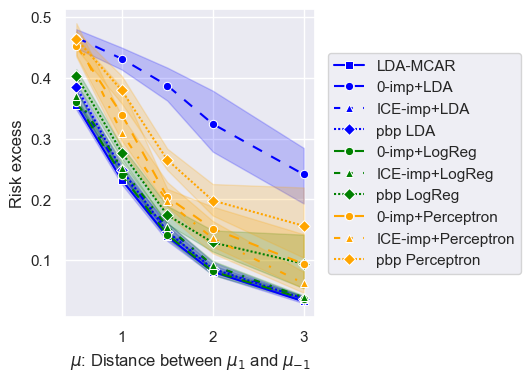

In [ ]:
# Learning curves : excess risk  
palette = {'LDA-MCAR': 'blue', '0-imp+LDA': 'blue', 'ICE-imp+LDA':'blue', 'pbp LDA':'blue', '0-imp+Perceptron':'orange', 'ICE-imp+Perceptron':'orange', 'pbp Perceptron': 'orange', '0-imp+LogReg': 'green', 'ICE-imp+LogReg':'green', 'pbp LogReg': 'green'}
markers = {'LDA-MCAR': 's', '0-imp+LDA': 'o', 'ICE-imp+LDA':'^', 'pbp LDA':'D', '0-imp+Perceptron':'o', 'ICE-imp+Perceptron':'^', 'pbp Perceptron': 'D', '0-imp+LogReg': 'o', 'ICE-imp+LogReg':'^', 'pbp LogReg': 'D'}
dashes = {'LDA-MCAR': (), '0-imp+LDA':(5, 5) , 'ICE-imp+LDA':(3, 5, 1, 5), 'pbp LDA':(1, 1), '0-imp+Perceptron':(5, 5), 'ICE-imp+Perceptron':(3, 5, 1, 5), 'pbp Perceptron': (1, 1), '0-imp+LogReg': (5, 5), 'ICE-imp+LogReg':(3, 5, 1, 5), 'pbp LogReg':(1, 1) }# (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={'figure.figsize':(4,4)})
sns.lineplot(data=df,x='dist',y='err',hue='Regressor',palette=palette,style='Regressor',markers=markers, dashes=dashes)

#plt.ylim((1e-2,1e3))
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

plt.subplots_adjust(right=0.75)
#plt.xscale('log')
#plt.yscale('log')


plt.ylabel('Risk excess')
plt.xlabel(r'$\mu$: Distance between $\mu_1$ and $\mu_{-1}$')
plt.savefig('dist-MCAR-iso.pdf',bbox_inches = 'tight')
plt.show()

With less sample size

In [ ]:
# Simulated dataset 
ntrain=50
ntest=1000
n=ntrain+ntest
d=5
k=2 #number of covariate by block 
eta=0.5

def gen_d(dist):
    mu_0=np.random.normal(loc=0, scale=5, size=(d))
    mu_1=mu_0+np.random.choice([1,-1], size=d)*dist
    return ToysMissingDataset(n=n,d=d,eta=eta,method='MCAR_iso',k=k, mu_0=mu_0, mu_1=mu_1)

In [ ]:
lst_reg= [LDA_MCAR(name="LDA-MCAR"),
          LDA0imputation(name="0-imp+LDA"),
          LDAICEimputation(name= "ICE-imp+LDA"),
          LDA_pbp(name="pbp LDA"),
          RegLog0imputation(name='0-imp+LogReg'),
          RegLogICEimputation(name="ICE-imp+LogReg"),
          #RegLogPatByPat( name="pbp LogReg"),
          Percep0imputation(name="0-imp+Perceptron"),
          PercepICEimputation(name="ICE-imp+Perceptron"),
          #PercepPatByPat(name="pbp Perceptron")
          ]

df=df_test_dist (lst_reg,gen_d,lst_dist=[3, 2, 1.5, 1, 0.5],n_train=ntrain, repeat=10,title="Isotropic",seed=0,b_risk=0, sigma=np.eye(d))

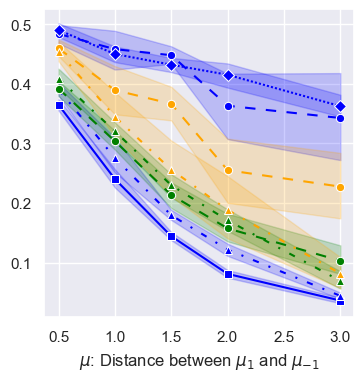

In [ ]:
# Learning curves : excess risk  
palette = {'LDA-MCAR': 'blue', '0-imp+LDA': 'blue', 'ICE-imp+LDA':'blue', 'pbp LDA':'blue', '0-imp+Perceptron':'orange', 'ICE-imp+Perceptron':'orange', 'pbp Perceptron': 'orange', '0-imp+LogReg': 'green', 'ICE-imp+LogReg':'green', 'pbp LogReg': 'green'}
markers = {'LDA-MCAR': 's', '0-imp+LDA': 'o', 'ICE-imp+LDA':'^', 'pbp LDA':'D', '0-imp+Perceptron':'o', 'ICE-imp+Perceptron':'^', 'pbp Perceptron': 'D', '0-imp+LogReg': 'o', 'ICE-imp+LogReg':'^', 'pbp LogReg': 'D'}
dashes = {'LDA-MCAR': (), '0-imp+LDA':(5, 5) , 'ICE-imp+LDA':(3, 5, 1, 5), 'pbp LDA':(1, 1), '0-imp+Perceptron':(5, 5), 'ICE-imp+Perceptron':(3, 5, 1, 5), 'pbp Perceptron': (1, 1), '0-imp+LogReg': (5, 5), 'ICE-imp+LogReg':(3, 5, 1, 5), 'pbp LogReg':(1, 1) }# (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={'figure.figsize':(4,4)})
sns.lineplot(data=df,x='dist',y='err',hue='Regressor',palette=palette,style='Regressor',markers=markers, dashes=dashes).get_legend().remove()

#plt.ylim((1e-2,1e3))
#plt.legend(loc=None)
#plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

#plt.subplots_adjust(right=0.75)


plt.ylabel('')
plt.xlabel(r'$\mu$: Distance between $\mu_1$ and $\mu_{-1}$')
plt.savefig('dist-MCAR-iso2.pdf',bbox_inches = 'tight')
plt.show()

## Missingness

In [ ]:
# Simulated dataset 
ntrain=50
ntest=1000
n=ntrain+ntest
d=5
k=2 #number of covariate by block 
dist=1.5

def gen_eta(eta):
    mu_0=np.random.normal(loc=0, scale=5, size=(d))
    mu_1=mu_0+np.random.choice([1,-1], size=d)*dist
    return ToysMissingDataset(n=n,d=d,eta=eta,method='MCAR_iso',k=k, mu_0=mu_0, mu_1=mu_1)

In [ ]:
lst_reg= [LDA_MCAR(name="LDA-MCAR"),
          LDA0imputation(name="0-imp+LDA"),
          LDAICEimputation(name= "ICE-imp+LDA"),
          LDA_pbp(name="pbp LDA"),
          RegLog0imputation(name='0-imp+LogReg'),
          RegLogICEimputation(name="ICE-imp+LogReg"),
          #RegLogPatByPat( name="pbp LogReg"),
          Percep0imputation(name="0-imp+Perceptron"),
          PercepICEimputation(name="ICE-imp+Perceptron"),
          #PercepPatByPat(name="pbp Perceptron")
          ]

df=df_test_dist(lst_reg,gen_eta,lst_dist=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],n_train=ntrain, repeat=10,title="Isotropic",seed=0,b_risk=0, sigma=np.eye(d))

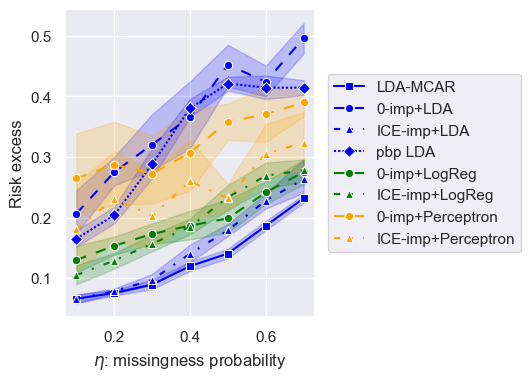

In [ ]:
# Learning curves : excess risk  
palette = {'LDA-MCAR': 'blue', '0-imp+LDA': 'blue', 'ICE-imp+LDA':'blue', 'pbp LDA':'blue', '0-imp+Perceptron':'orange', 'ICE-imp+Perceptron':'orange', 'pbp Perceptron': 'orange', '0-imp+LogReg': 'green', 'ICE-imp+LogReg':'green', 'pbp LogReg': 'green'}
markers = {'LDA-MCAR': 's', '0-imp+LDA': 'o', 'ICE-imp+LDA':'^', 'pbp LDA':'D', '0-imp+Perceptron':'o', 'ICE-imp+Perceptron':'^', 'pbp Perceptron': 'D', '0-imp+LogReg': 'o', 'ICE-imp+LogReg':'^', 'pbp LogReg': 'D'}
dashes = {'LDA-MCAR': (), '0-imp+LDA':(5, 5) , 'ICE-imp+LDA':(3, 5, 1, 5), 'pbp LDA':(1, 1), '0-imp+Perceptron':(5, 5), 'ICE-imp+Perceptron':(3, 5, 1, 5), 'pbp Perceptron': (1, 1), '0-imp+LogReg': (5, 5), 'ICE-imp+LogReg':(3, 5, 1, 5), 'pbp LogReg':(1, 1) }# (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={'figure.figsize':(4,4)})
sns.lineplot(data=df,x='dist',y='err',hue='Regressor',palette=palette,style='Regressor',markers=markers, dashes=dashes)

#plt.ylim((1e-2,1e3))
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

plt.subplots_adjust(right=0.75)
#plt.xscale('log')
#plt.yscale('log')


plt.ylabel('Risk excess')
plt.xlabel(r'$\eta$: missingness probability')
plt.savefig('missingness-MCAR-iso2.pdf',bbox_inches = 'tight')
plt.show()

## Dimension

In [ ]:
# Simulated dataset 
ntrain=50
ntest=1000
n=ntrain+ntest
k=2 #number of covariate by block 
dist=1.5
eta=0.5

def gen_dim(dim):
    mu_0=np.random.normal(loc=0, scale=5, size=(dim))
    mu_1=mu_0+np.random.choice([1,-1], size=dim)*dist
    return ToysMissingDataset(n=n,d=dim,eta=eta,method='MCAR_iso',k=k, mu_0=mu_0, mu_1=mu_1)

: 

In [ ]:
lst_reg= [LDA_MCAR(name="LDA-MCAR"),
          LDA0imputation(name="0-imp+LDA"),
          LDAICEimputation(name= "ICE-imp+LDA"),
          LDA_pbp(name="pbp LDA"),
          RegLog0imputation(name='0-imp+LogReg'),
          RegLogICEimputation(name="ICE-imp+LogReg"),
          #RegLogPatByPat( name="pbp LogReg"),
          Percep0imputation(name="0-imp+Perceptron"),
          PercepICEimputation(name="ICE-imp+Perceptron"),
          #PercepPatByPat(name="pbp Perceptron")
          ]
df=df_test_dist(lst_reg,gen_dim,lst_dist=[2, 4, 5, 8, 10, 15, 30],n_train=ntrain, repeat=10,title="Isotropic",seed=0,b_risk=0, sigma=np.eye(30))

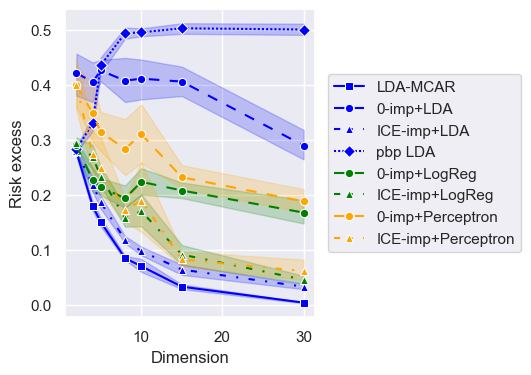

In [ ]:
# Learning curves : excess risk  
palette = {'LDA-MCAR': 'blue', '0-imp+LDA': 'blue', 'ICE-imp+LDA':'blue', 'pbp LDA':'blue', '0-imp+Perceptron':'orange', 'ICE-imp+Perceptron':'orange', 'pbp Perceptron': 'orange', '0-imp+LogReg': 'green', 'ICE-imp+LogReg':'green', 'pbp LogReg': 'green'}
markers = {'LDA-MCAR': 's', '0-imp+LDA': 'o', 'ICE-imp+LDA':'^', 'pbp LDA':'D', '0-imp+Perceptron':'o', 'ICE-imp+Perceptron':'^', 'pbp Perceptron': 'D', '0-imp+LogReg': 'o', 'ICE-imp+LogReg':'^', 'pbp LogReg': 'D'}
dashes = {'LDA-MCAR': (), '0-imp+LDA':(5, 5) , 'ICE-imp+LDA':(3, 5, 1, 5), 'pbp LDA':(1, 1), '0-imp+Perceptron':(5, 5), 'ICE-imp+Perceptron':(3, 5, 1, 5), 'pbp Perceptron': (1, 1), '0-imp+LogReg': (5, 5), 'ICE-imp+LogReg':(3, 5, 1, 5), 'pbp LogReg':(1, 1) }# (): cont (1,1) dotted (5,5) dashed (3,5,1,5) dashdot

sns.set(rc={'figure.figsize':(4,4)})
sns.lineplot(data=df,x='dist',y='err',hue='Regressor',palette=palette,style='Regressor',markers=markers, dashes=dashes)

#plt.ylim((1e-2,1e3))
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

plt.subplots_adjust(right=0.75)
#plt.xscale('log')
#plt.yscale('log')


plt.ylabel('Risk excess')
plt.xlabel(r'Dimension')
plt.savefig('dim-MCAR-iso2.pdf',bbox_inches = 'tight')
plt.show()

For the Legend:

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define styles for each category
legend_labels = ['LDA-MCAR', '0-imp+LDA', 'ICE-imp+LDA', 'pbp LDA',
                  '0-imp+Perceptron', 'ICE-imp+Perceptron', 'pbp Perceptron',
                  '0-imp+LogReg', 'ICE-imp+LogReg', 'pbp LogReg']

# Define color, marker, and line style for each label
palette = {'LDA-MCAR': 'blue', '0-imp+LDA': 'blue', 'ICE-imp+LDA': 'blue', 'pbp LDA': 'blue',
           '0-imp+Perceptron': 'orange', 'ICE-imp+Perceptron': 'orange', 'pbp Perceptron': 'orange',
           '0-imp+LogReg': 'green', 'ICE-imp+LogReg': 'green', 'pbp LogReg': 'green'}

markers = {'LDA-MCAR': 's', '0-imp+LDA': 'o', 'ICE-imp+LDA': '^', 'pbp LDA': 'D',
           '0-imp+Perceptron': 'o', 'ICE-imp+Perceptron': '^', 'pbp Perceptron': 'D',
           '0-imp+LogReg': 'o', 'ICE-imp+LogReg': '^', 'pbp LogReg': 'D'}

dashes = {'LDA-MCAR': '', '0-imp+LDA': '--', 'ICE-imp+LDA': '-.', 'pbp LDA': ':',
          '0-imp+Perceptron': '--', 'ICE-imp+Perceptron': '-.', 'pbp Perceptron': ':',
          '0-imp+LogReg': '--', 'ICE-imp+LogReg': '-.', 'pbp LogReg': ':'}

# Create handles for the legend
handles = []
for label in legend_labels:
    line = Line2D([0], [0], color=palette[label], marker=markers[label], linestyle=dashes[label], markersize=10, linewidth=2, label=label)
    handles.append(line)

# Create a larger figure to ensure the legend takes up the full space
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size as needed

# Create the legend
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize='large')

# Remove the axis (empty plot)
ax.axis('off')

# Save the legend to a PDF
plt.savefig('legend.pdf', bbox_inches='tight', pad_inches=0.2)

# Close the plot
plt.close(fig)
